### Credits
ROI drawing and saving: John

Lit plots with interactive legends: John

Data tidying: Jared

normalization: Jared + John

Period analysis: (mostly) Jared + (some) John

Period/Inactivity Plots: Jared + John

## Problem 3.2: Pulsing jellyfish (50 pts)

In [Tutorial 3b](../tutorials/t3b_extracting_info_from_images.html), we extracted information from movies of pulsing jellyfish. Using these images (which you can download [here](../data/cassiopea_pulsation.zip), analyze both the daytime and nighttime movies. Compare and contrast the measurements both between daytime and nighttime and among the individual jellyfish. Discuss any conclusions or suggestions for further experiments you may have.

*This question is intentionally open-ended. Think carefully about what you want to do and how you interpret what you see.*

## Solution

In [1]:
import glob
import os
import sys

import numpy as np
import pandas as pd
import scipy.signal

# Image processing tools
import skimage
import skimage.io

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat

import bebi103
import bokeh
from bokeh.palettes import Dark2_5 as palette
import itertools
from bokeh.models import Legend, LegendItem
bokeh.io.output_notebook()

C:\Users\Christina\Anaconda3\envs\be103\lib\site-packages\bebi103\viz.py:30: UserWarning: DataShader import failed with error "No module named 'datashader'".
Features requiring DataShader will not work and you will get exceptions.
  Features requiring DataShader will not work and you will get exceptions.""")


Loading BokehJS ...

The first step to analyzing this data is loading it, defining ROIs, and plotting the frequencies. My annotations of this process will be sparse because it is taken verbatum from tutorial 3b. 

First I will get filenames for image data.

In [2]:
# The directory containing daytime data
data_dir_day = '../data/Cassiopea_Pulsation/day'
data_dir_night = '../data/Cassiopea_Pulsation/night'

# Glob string for images
im_glob_day = os.path.join(data_dir_day, '*.TIF')
im_glob_night = os.path.join(data_dir_night, '*.TIF')

# Get list of files in directory
im_list_day = sorted(glob.glob(im_glob_day))
im_list_night = sorted(glob.glob(im_glob_night))

# Check to make sure we have the right filenames.
im_list_night[:5]

['../data/Cassiopea_Pulsation/night\\Frame_545000.TIF',
 '../data/Cassiopea_Pulsation/night\\Frame_545001.TIF',
 '../data/Cassiopea_Pulsation/night\\Frame_545002.TIF',
 '../data/Cassiopea_Pulsation/night\\Frame_545003.TIF',
 '../data/Cassiopea_Pulsation/night\\Frame_545004.TIF']

The filenames look good. Brief validation that the images are greyscale was performed in the tutorial, so I will assume that here, and efficiently load the images as an image collection using sci-kit image and tutorial code. 

In [3]:
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

# Load in day images
ic_day = skimage.io.ImageCollection(im_glob_day,
                                    conserve_memory=True, 
                                    load_func=squish_rgb)

# Load in night images
ic_night = skimage.io.ImageCollection(im_glob_night,
                                      conserve_memory=True, 
                                      load_func=squish_rgb)

I will also make time series for both image collections, assuming again that the rate is 15 frames per second. 

In [4]:
fps = 15
t_day = np.arange(0, len(ic_day)) / fps
t_night = np.arange(0, len(ic_night)) / fps
t_night, t_day

(array([0.00000000e+00, 6.66666667e-02, 1.33333333e-01, ...,
        2.66466667e+02, 2.66533333e+02, 2.66600000e+02]),
 array([0.00000000e+00, 6.66666667e-02, 1.33333333e-01, ...,
        2.66466667e+02, 2.66533333e+02, 2.66600000e+02]))

Looks like both datasets are about 267 seconds long, which seems reasonable. 

Dr. Bois said that the jellyfish will not shift during the experiment, for which we are very thankful. Thus, we will draw a set of ROIs for each image collection, one ROI per jellyfish. 

The following code checks to see if there is already an ROI file, and prompts you to draw rois if there is not. Otherwise, it simply loads the ROIs into a dataframe. 

In [5]:
df_rois = None
try:
    df_rois = pd.read_csv("./roi_dataframe.csv")
    df_rois = df_rois.drop(["Unnamed: 0"], axis = 1)
except:
    print("ROIs not found. Please draw ROIs, or place them in the appropriate directory.")
    # Read in the first images using skimage
    im_day = skimage.io.imread(im_list_day[0])

    # Draw day ROIs
    print("Please draw day ROIs.")
    rois_day = bebi103.viz.draw_rois(im_day, flip=False)

We are specifically drawing the ROIs such that the jellyfish are numbered 0-3 on the top row and 4-7 on the bottom row. This is true for both day and night image series. 

Now to draw night ROIs, if not already drawn. 

In [6]:
if type(df_rois) == type(None):
    print("Please draw night ROIs before executing the next cell.")
    im_night = skimage.io.imread(im_list_day[0])
    rois_night = bebi103.viz.draw_rois(im_night, flip=False)

Looks great! Now it is time to add night/day fields and save the ROIs as a csv, so that you never ever ever ever have to draw them again. 

In [7]:
if type(df_rois) == type(None):
    # Turn the ROIs into dataframes
    df_rois_day = bebi103.viz.roicds_to_df(rois_day)
    df_rois_night = bebi103.viz.roicds_to_df(rois_night)
    
    # Add a day or a night column
    daytime_arr = ["day"] * len(df_rois_day.index)
    nighttime_arr = ["night"] * len(df_rois_night.index)
    df_rois_day["time_of_day"] = daytime_arr
    df_rois_night["time_of_day"] = nighttime_arr
    
    # Save ROIs as a .csv
    df_rois = pd.concat([df_rois_day, df_rois_night])
    df_rois.to_csv(path_or_buf="./roi_dataframe.csv")

Lets take a look at our new roi dataframe:

In [8]:
df_rois.head()

,roi,x,y,time_of_day
0,0,115.637472,259.532143,day
1,0,94.983370,281.807143,day
2,0,91.363636,320.437500,day
3,0,106.424612,355.591071,day
4,0,159.052106,363.321429,day


<p style="background-color:#D9EDF7">
    -1: Here, it would be helpful to visualize the ROIs as well.<br>
</p>

Now I want to begin the process of transforming these image series into a simple timeseries of intensity values within the roi. First I will obtain an the parameters of all the ROIs, such as the bounding box. 

In [9]:
im_night = skimage.io.imread(im_list_night[0])
im_day = skimage.io.imread(im_list_day[0])

# Manually reduce image dimensionality. 
im_day = im_day[:,:,0]
im_night = im_night[:,:,0]

# Obtain the ROI parameters for all ROIs using a streamlined  function from bebi103. 
rois_day = [bebi103.image.verts_to_roi(g[['x', 'y']].values, *im_day.shape)
            for _, g in df_rois[df_rois['time_of_day']=='day'].groupby('roi')]

rois_night = [bebi103.image.verts_to_roi(g[['x', 'y']].values, *im_night.shape)
            for _, g in df_rois[df_rois['time_of_day']=='night'].groupby('roi')]

I need to define the loading function for loading only the roi portion of an image. This will make the caclulation of pixel intensities across the image collection much faster. 

In [10]:
# Define load_func that only gives region bounding ROI
def load_roi(fname, roi_bbox=None, **kwargs):
    """
    Image loading function to only load ROI.
    """
    if roi_bbox is None:
        return skimage.io.imread(fname)[:,:,0]
    else:
        return skimage.io.imread(fname)[:,:,0][roi_bbox]

This next cell will take some time to run; it loops through all the ROIs, finds the total pixel intensity within the roi at each timepoint, and saves the value in a dataframe. Since it is a computation-heavy cell, I'm going to save the output permanently, and keep it in a try block. If we wanted to re-run the calculation, perhaps because we drew new ROIs, we would just have to delete the output of this function and re-run it. 

In [11]:
df_roi_intensities = None
try:
    # This executes if we have already done the computation
    df_roi_intensities = pd.read_csv("./roi_intensities_all.csv")
    df_roi_intensities = df_roi_intensities.drop(["Unnamed: 0"], axis = 1)
except:
    # Here comes the computation
    
    # This will be used to store the pixel intensity over time. 
    df_roi_intensities = pd.DataFrame(t_day, columns = ["time"])

    # I'm looping through all the rois, and creating an array that stores
    # pixel-intensity over time. This loop works because both day and night
    # have the same number of rois. 
    for roi in set(df_rois["roi"].values): # set reduces the array to unique values
        # Establish the ROI parameters
        roi_day, roi_bbox_day, roi_box_day = rois_day[roi]
        roi_night, roi_bbox_night, roi_box_night = rois_night[roi]

        # I now need to re-load the image collections using the roi box as a bound. 
        ic_day = skimage.io.ImageCollection(im_glob_day, conserve_memory=True, 
                                            load_func=load_roi, roi_bbox=roi_bbox_day)
        ic_night = skimage.io.ImageCollection(im_glob_night, conserve_memory=True, 
                                              load_func=load_roi, roi_bbox=roi_bbox_night)

        # Set up NumPy array to store total pixel intensity
        total_int_day = np.empty(len(t_day))
        total_int_night = np.empty(len(t_night))

        # Look through and compute total intensity in the ROI
        for i, im in enumerate(ic_day):
            total_int_day[i] = ic_day[i][roi_box_day].sum()
        for i, im in enumerate(ic_night):
            total_int_night[i] = ic_night[i][roi_box_night].sum()

        # Append pixel intensities over time to the dataframe we started with
        df_roi_intensities["sum_int_day_roi%i"%roi] = total_int_day
        df_roi_intensities["sum_int_night_roi%i"%roi] = total_int_night

        # Save the result permenantly, so as not to waste computation time in the future
        df_roi_intensities.to_csv("./roi_intensities_all.csv")

That was a non-trivial code block, but we are really close to finally being able to visualize this dataset! Let's check the dataframe to make sure it looks like it should.

In [12]:
df_roi_intensities.head()

,time,sum_int_day_roi0,sum_int_night_roi0,sum_int_day_roi1,sum_int_night_roi1,sum_int_day_roi2,sum_int_night_roi2,sum_int_day_roi3,sum_int_night_roi3,sum_int_day_roi4,sum_int_night_roi4,sum_int_day_roi5,sum_int_night_roi5,sum_int_day_roi6,sum_int_night_roi6,sum_int_day_roi7,sum_int_night_roi7
0,0.000000,22229472.0,188186194.0,66194976.0,150804773.0,95903662.0,251299226.0,22686161.0,157363927.0,26376424.0,54849197.0,47667332.0,147244038.0,40236948.0,91040194.0,18709086.0,161980932.0
1,0.066667,21535315.0,183982959.0,67260241.0,158250320.0,95580356.0,248097263.0,29545491.0,153261179.0,25076004.0,54036563.0,46520084.0,143860890.0,45460730.0,89918903.0,18781303.0,157481633.0
2,0.133333,20081723.0,178516826.0,66816659.0,163158249.0,96805475.0,246252517.0,33613801.0,151430825.0,23903827.0,53996728.0,49885756.0,142363608.0,49850547.0,89947430.0,18602945.0,154546179.0
3,0.200000,18218473.0,172813996.0,71470415.0,162034388.0,101359001.0,246295950.0,34260927.0,150542890.0,23150817.0,54202328.0,54944801.0,141480556.0,52039159.0,90007311.0,18508883.0,152622534.0
4,0.266667,15979232.0,170028116.0,83592848.0,161058559.0,110046372.0,248696073.0,34066635.0,151793966.0,22580534.0,55090263.0,57875886.0,143160308.0,52254525.0,91251705.0,18474188.0,153323373.0


Okay, we have the series, so let's plot it. I feel that plotting it is very likely to lend intuition about how to approach further analysis of the dataset. 

In [13]:
p = bokeh.plotting.figure(plot_width=850,
                          plot_height=400,
                          x_axis_label='time (s)', 
                          y_axis_label='total intensity')

# I have to store the plots in an array to creatively work with the legend
index = 0
plots = [0]*16

# Deals with coloring of different lines
colors = itertools.cycle(palette)

first = True # used to only show the first plot. 

for roi, color in zip(range(0,16), colors):
    
    # We have numbered the ROIs from 1-16 in our dataframe so that the roi would 
    # be a unique ID, but the Jellyfish at ROIs (0, 8), (1, 9), etc. are the same, 
    # and we want the plot to reflect this. 
    daytime = 'day'
    if roi >= 8:
        roi -= 8
        daytime = 'night'
    name = "sum_int_%s_roi%i" % (daytime, roi)
    
    q = p.line(df_roi_intensities['time'].values, 
               df_roi_intensities[name].values, 
               line_width=1,
               color = color,
               visible = first, # used to only show the first plot. 
               line_join='bevel')
    name = "ROI %i %s" % (roi, daytime)
    
    # I must store the plots as legendItems so that I can make a cool legend. 
    plots[index] = LegendItem(label=name, renderers=[q])
    
    # Indexing to keep track of plots array
    index += 1
    
    first = False # used to only show the first plot. 

# Make a super cool legend!!
legend = Legend(items=plots,
                location=(0,-20),
                click_policy = "hide")

# Place the massive legend outside the plot area
p.add_layout(legend, 'right')

bokeh.io.show(p)

These plots are scattered all over the canvas! It appears that we need to normalize prior to further analysis. Normalizing takes a few minutes to run, and it is a massive code block, so I am going to use a similar try block to save us computation time in re-running this code over and over. **I apologize for the nature of the very long code block, this is done because of the continuous try statement.** In place of markdown cells, I've used multi-line comments. 

In [14]:
try:
    # This executes if we have already done the computation
    df_tidy_roi_int = pd.read_csv("./roi_intensities_normalized.csv")
    df_tidy_roi_int = df_tidy_roi_int.drop(["Unnamed: 0"], axis = 1)
except:
    """The dataframe we just loaded was not tidy, so the first major step
       we will undertake is to tidy the data. """

    # Index by time, compress, sort, and index by the top level 
    df_tidy_roi_int = df_roi_intensities.set_index(['time']).stack(level=0)
    df_tidy_roi_int = df_tidy_roi_int.sort_index(level=1)
    df_tidy_roi_int = df_tidy_roi_int.reset_index(level=1)

    # Make time a column again
    df_tidy_roi_int = df_tidy_roi_int.reset_index(level=0)

    # Separate the compressed indices data into its own dataframe, 
    # and split into separate columns.
    new_indices = df_tidy_roi_int.level_1.str.split("_").apply(pd.Series)

    # Drop unnecessary columns
    new_indices = new_indices.drop(columns = [0,1])
    df_tidy_roi_int = df_tidy_roi_int.drop(columns = ['level_1',])

    # Make index its own column so there's a shared column and merge
    new_indices = new_indices.reset_index(level=0)
    df_tidy_roi_int = df_tidy_roi_int.reset_index(level=0)
    df_tidy_roi_int = pd.merge(df_tidy_roi_int, new_indices)

    # Give the columns useful names
    df_tidy_roi_int = df_tidy_roi_int.rename(columns={0:'sum_int', 
                                                      2: 'Condition', 
                                                      3:'ROI'})

    # Get rid of the ROI letters
    df_tidy_roi_int["ROI"] = df_tidy_roi_int.ROI.str[3:4]
    df_tidy_roi_int["ROI"] = df_tidy_roi_int['ROI'].astype(int)

    # Reorganizing the columns, dropping redundant index column
    df_tidy_roi_int = df_tidy_roi_int[['time','Condition','ROI','sum_int']]

    # Now I will make roi values unique, to save me from later headaches
    # ROI will now range from 0 to 15. 
    df_tidy_roi_int["ROI"] = df_tidy_roi_int["ROI"].values \
                             + (df_tidy_roi_int["Condition"]=="night")*8

    
    """Okay, now the data is tidy, but it still needs to be normalized. To 
    do this, we need to find the mean, max, and min for each ROI, and 
    permanently store it so that we do not waste computation time recomputing
    the values for every point. """
    roi = range(0, 16)
    
    # d_temp will store statistics about each ROI, and will eventually 
    # be merged with the tidy dataframe. 
    d_temp = pd.DataFrame({"ROI" : range(0, 16)})

    means = np.empty([0])
    mins = np.empty([0])
    maxes = np.empty([0])
    for r in range(0, 16):
        # Loop through all the ROIs and compute statistics. 
        sub_df = df_tidy_roi_int[df_tidy_roi_int["ROI"]==r]
        means = np.append(means, np.average(sub_df["sum_int"].values))
        mins = np.append(mins, np.min(sub_df["sum_int"].values))
        maxes = np.append(maxes, np.max(sub_df["sum_int"].values))
        
    # Append the statistics to the temporary dataframe
    d_temp["mean"] = means
    d_temp["min"] = mins
    d_temp["max"] = maxes
    
    # Merge Statistic data with original data
    df_tidy_roi_int = pd.merge(d_temp, df_tidy_roi_int)

    def normalize_int(index):
        """This normalizes a single timepoint with respect to the mean, minimum, 
        and maximum intensity values for the entire ROI that the timepoint is from.
        Final values are scaled along [-1, +1]."""
        # Set up Boolean slicing
        daytime = (df_tidy_roi_int['Condition'] == 
                   df_tidy_roi_int['Condition'].iloc[index])
        jellyfish = (df_tidy_roi_int['ROI'] == 
                     df_tidy_roi_int['ROI'].iloc[index])
        sum_intensity = df_tidy_roi_int['sum_int'].iloc[index]

        # Make temporary dataframe
        df_roi_temp = df_tidy_roi_int.loc[daytime & jellyfish, :]

        # Recall mean, max, min, and subtract the mean from the max and the min
        # for normalization. 
        mean_int = df_roi_temp['mean'].values[0]
        max_int = df_roi_temp['max'].values[0] - mean_int
        min_int = df_roi_temp['min'].values[0] - mean_int

        # Normalize
        difference = sum_intensity - mean_int
        normal_int = 1 + 2 * ((difference - max_int) 
                        / (max_int - min_int))

        return normal_int 
    
    # This will be an array that stores all normalized intensity values
    normalized_int = np.empty([len(df_tidy_roi_int.index)])
    
    # Now I will loop through every timepoint we have for every jellyfish, 
    # and normalize it. 
    for k in range(0, len(df_tidy_roi_int.index)):
        sys.stdout.write("\r%.2f percent done."%(100 * k/len(df_tidy_roi_int)))
        normalized_int[k] = normalize_int(df_tidy_roi_int.index[k])
    sys.stdout.write("\r100 percent done.\n")
    df_tidy_roi_int['normal_int'] = normalized_int
    df_tidy_roi_int.to_csv("./roi_intensities_normalized.csv")

Great! Now our data is both tidy and normalized! Let's see what our dataframe looks like now:

In [15]:
df_tidy_roi_int.head()

,ROI,mean,min,max,time,Condition,sum_int,normal_int
0,0,1.104883e+07,4800760.0,23236141.0,0.000000,day,22229472.0,0.890789
1,0,1.104883e+07,4800760.0,23236141.0,0.066667,day,21535315.0,0.815482
2,0,1.104883e+07,4800760.0,23236141.0,0.133333,day,20081723.0,0.657787
3,0,1.104883e+07,4800760.0,23236141.0,0.200000,day,18218473.0,0.455648
4,0,1.104883e+07,4800760.0,23236141.0,0.266667,day,15979232.0,0.212719


Now that we have normalized, let's redo the plots and see if we can make some more sense out of them!

In [16]:
# First create the overall figure
p = bokeh.plotting.figure(plot_width=850,
                          plot_height=400,
                          x_axis_label='time (s)', 
                          y_axis_label='total intensity')

# Deals with coloring of different lines
colors = itertools.cycle(palette)

# I have to store the plots in an array to creatively work with the legend
index = 0
plots = [0]*16

first = True # used to only show the first plot. 

for roi, color in zip(range(0,16), colors):
    daytime = df_tidy_roi_int[df_tidy_roi_int["ROI"] == roi]['Condition'].values[0]
    sub_df = df_tidy_roi_int[df_tidy_roi_int["ROI"] == roi]
    q = p.line(sub_df['time'].values, 
               sub_df['normal_int'].values, 
               line_width=1, 
               color = color,
               visible = first, # used to only show the first plot. 
               line_join='bevel')
    
    # I want to keep the ROI numbers consistent with the earlier plot
    name = "ROI %i %s" % (roi - 8*(daytime == "night"), daytime)
    plots[index] = LegendItem(label=name, renderers=[q])
    
    # Indexing to keep track of plots array
    index += 1
    first = False # used to only show the first plot. 
    
# Awesome legend!
legend = Legend(items=plots,
                location=(0,-20),
                click_policy = "hide")

p.add_layout(legend, 'right')
bokeh.io.show(p)

By far, the most remarkable aspect of this dataset is the sharp transition of jellyfish behavior from prolonged inactive states to oscillatory active states. **For the rest of this assignment, we will focus on 2 potential aspects of jellyfish sleeping behavior:**
1. How does the prolonged ceases in pulsating activity relate to time of day?
2. Does pulsating frequency change from day to night?

The smallest pauses in pulsating behavior I can find that appear to not simply be noise are around 3 seconds long. Furthermore, all inactive points appear to have normalized intensity values less than zero. Thus, I will create a function that goes through these timeseries, and determines whether the state is inactive or active. I will begin by creating a function to define whether a given point is a local maximum or not. Determining maximums will allow us to isolate periods of activity; from there, we can analyze pulse frequency by looking at the time between maxima during active periods.

In [17]:
def is_max(index, df):
    """This function determines whether a given index of a dataframe 
       is a local maximum. """
    # We begin by defining the indices on either side of our point of interest
    pre = index - 1
    post = index + 1
    
    # We don't care about local maxima below 0 because they appear to be noise 
    # and not oscillations.
    if df['normal_int'].iloc[index] <=0:
        return False
    
    # We don't care about "local maxima" that are on the edges of the dataframe
    # because we can't verify if they are true maxima.
    elif pre < 0:
        return False
    elif post == len(df):
        return False
    
    # Define the intensity values at the three points
    pre_int = df['normal_int'].iloc[pre]
    our_int = df['normal_int'].iloc[index]
    post_int = df['normal_int'].iloc[post]
    # Check if ours is the max
    return our_int == np.max([pre_int, our_int, post_int])

# Time to apply our maximum function to our dataframe!

def count_max(df):
    """This function will create a new column in the dataframe that denotes
       whether that point is a maximum."""
    maxima = np.empty([len(df.index)])
    
    # Loop through entire dataframe!
    for k in range(0, len(df.index)):
        maxima[k] = is_max(df.index[k], df)
        
    # Append output of maximum function to argument dataframe. 
    df['Maxima'] = maxima
    df['Maxima'] = df['Maxima'].astype(bool)
    return 

Now that we can tell whether a point is a maximum or not, we can calculate the period between maxima to understand the period of oscillation. We can also place an upper bound of 3 seconds, as described earlier, on what we call normal oscillation, and define any points with periods between maxima of greater than three seconds as not being active.

In [18]:
def calculate_period(df):
    """This function will create new columns denoting whether a point is part of an active period
       and, if a point is a maxima, the length of the period between that maxima and the previous
       maxima."""
    
    # Create empty numpy arrays to fill with the period and activity information
    periods = np.empty([len(df.index)])
    activity = np.empty([len(df.index)])
    
    for k in range(0, len(df.index)):
        # Deal with the point at the beginning of the dataframe
        
        if k == 0:
            # Holds the length of time since the previous maxima.
            length = 0
            # Denotes the length of time since the previous maxima, if the point
            # is a maximum.
            period = 0
            # Denotes whether the jellyfish is active at this point.
            Activity = True
        
        # If the point is a maxima, set the period to be the time since the previous maxima.
        elif df['Maxima'].iloc[k] == True:
            period = length * .066667
            
            if length * .066667 >= 3:
                # If the period is greater than 3 seconds, this maxima is the end of an inactive period
                # so it isn't an active point.
                Activity = False
            
            else:
                # If the period is less than 3 seconds, this maxima is part of an active period.
                Activity = True
            # Reset the length
            length = 0
            
        else:
            # If the point is not a maximum, period is 0 and we add 1 to the length.
            period = 0
            length = length + 1
            
            if length * .066667 >= 3:
                Activity = False
            else:
                Activity = True
                
        # Add the information to the arrays  
        periods[k] = period
        activity[k] = Activity
        
    # Add the arrays to the dataframe
    df['Period'] = periods
    df['Activity'] = activity

Since we have defined inactivity as any period between maxima greater than 3 seconds, we can just note that any period greater than 3 seconds is also a period of inactivity very easily to get a column that displays the inactivity

In [19]:
def calculate_inactivity(df):
    Inactivity = np.empty([len(df.index)])
    for k in range(0, len(df.index)):
        if df['Period'].iloc[k] > 3:
            inactivity = df['Period'].iloc[k]
        else:
            inactivity = 0       
            
        Inactivity[k] = inactivity
    df['Inactivity'] = Inactivity


That was a lot of function definitions, but we just need a few more more!

We can finally make a function that calls all these functions and applies them to a dataframe.

In [20]:
def max_activity_period(df):
    """Applies maximum and period analysis functions to a given dataframe."""
    df = df.reset_index(level=0)
    count_max(df)
    calculate_period(df)
    calculate_inactivity(df)
    return df

I will now make ECDF plots of the oscillation period distribution for each jellyfish, comparing frequencies from the night and from the day. It is reasonable to hypothesize that the jellyfish might oscillate slower, and with a higher period during the night, because they are "sleepier." Let's see if this is correct!

We will begin plotting by making a general ECDF plotting function, since we want to make 8 graphs.

In [21]:
def make_ecdf(df, title):
    c = altcat.catplot(data=df,
                       mark='line',
                       encoding=dict(x=alt.X('Period:Q'),
                                     color = alt.Color('Condition:N', 
                                                       title='Time of Day',
                                                       scale=alt.Scale(domain=['day', 'night'],
                                                                       range=['orange', 'blue']))),
               transform='ecdf'
              ).properties(height=300,
                           width=300,
                           title = title)
    return c

We are finally equipped to apply all of our previous period analysis code to each ROI one at a time, and plot the resulting distribution for day and night!

In [22]:
# Store ECDFs so that they may be conveniently formatted. 
ecdfs = [0]*8

# The processed data will be saved in a new dataframe so
# that we can avoid repeating the processing for future plots. 
df_master = None

# Loop through ROIs
for roi in range(0, 8):
    # Loading bar!
    sys.stdout.write("\r%.2f percent done."%(100 * roi/8))
    
    # First I will extract dataframes for 1 jellyfish at a time,
    # simultaneously obtaining both night and day data. 
    df_day = df_tidy_roi_int[df_tidy_roi_int["ROI"] == roi]
    df_night = df_tidy_roi_int[df_tidy_roi_int["ROI"] == roi + 8]
    
    # Here I need to perform period and acivity analysis on both
    # day and night dataframes. 
    df_day = max_activity_period(df_day)
    df_night = max_activity_period(df_night)
    
    # Concatenate day and night dataframes so I can plot them on 
    # the same ECDF. 
    df = pd.concat([df_night[(df_night["Period"] > 0) & (df_night["Period"] < 3)], 
                    df_day[(df_day["Period"] > 0) & (df_day["Period"] < 3)]])
    
    if type(df_master) == type(None):
        df_master = pd.concat([df_day, df_night])
    else:
        df_master = pd.concat([df_master, df_day, df_night])
    
    ecdfs[roi] = make_ecdf(df, "Jellyfish at ROI %i"%roi)
sys.stdout.write("\r100 percent done.\n")

100 percent done.


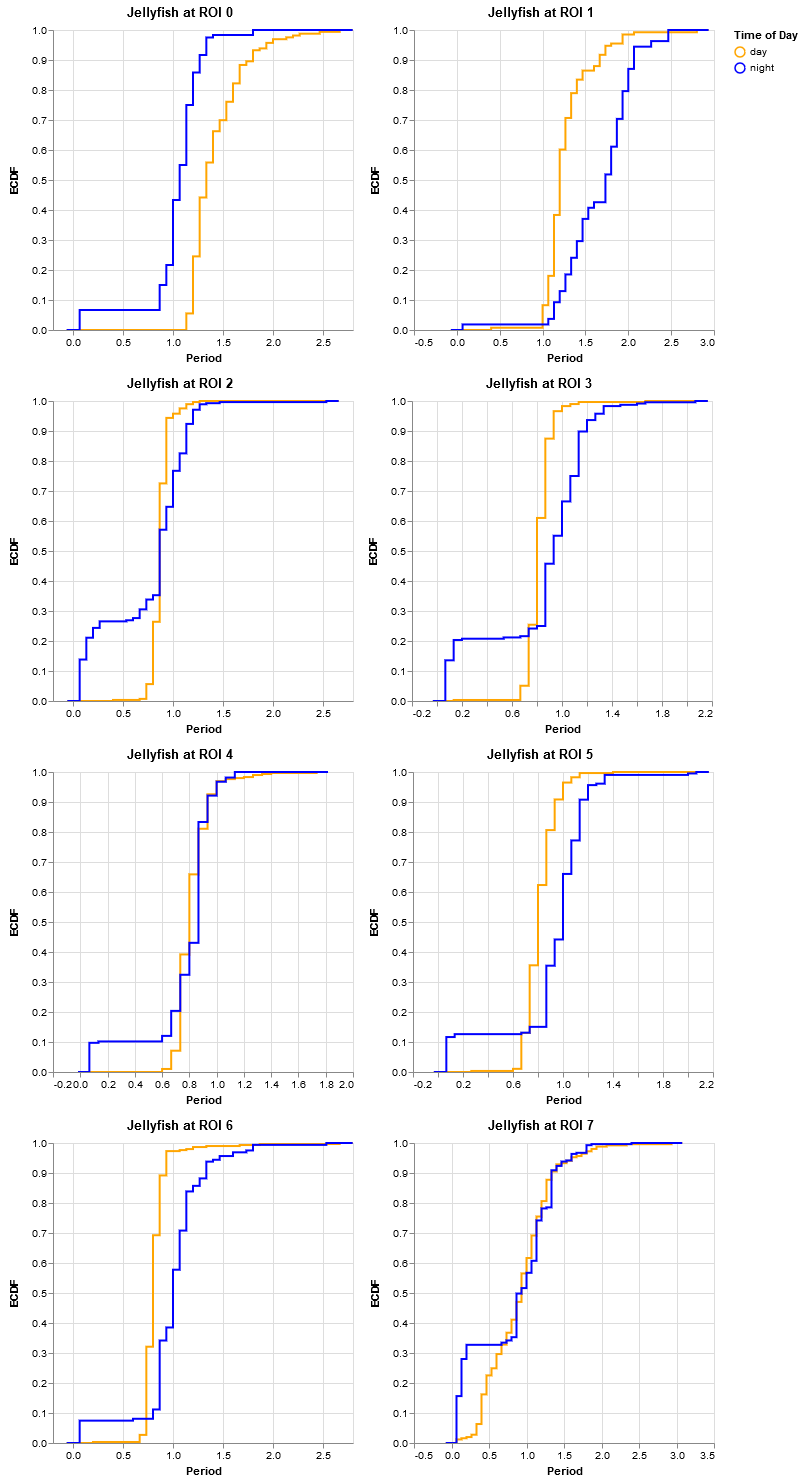

In [23]:
(ecdfs[0] | ecdfs[1]) & (ecdfs[2] | ecdfs[3]) & (ecdfs[4] | ecdfs[5]) & (ecdfs[6] | ecdfs[7])

This is a very interesting set of results! It appears that, so long as the jellyfish is in an active (pulsating) state, the pulsating frequency or period appears not to be at all dependent on time of day. Whether the jellyfish pulsated faster at night rather than during the day seems really to only depend on the jellyfish. We can now find the average frequency so that we have a more concrete parameter:

In [24]:
def calculate_frequency(df):
    """Accepts a dataframe that contains the points that correspond 
       to only periods of activity for a single jellyfish in a single ROI.
       Returns the oscillation frequency in that period."""
    frequency = df['Maxima'].sum() / (len(df) * .066667) 
    return frequency

def active_frequency(df, ROI):
    """Accepts the master dataframe and an ROI. Returns the average oscillation frequency 
       within the active periods of jellyfish activity."""
    temp_df = df[(df['Activity'] == 1.0) & 
                 ((df['ROI'] == ROI) & (df['Period'] < 3))]
    temp_df = temp_df.reset_index(level=0)
    count_max(temp_df)
    frequency = calculate_frequency(temp_df)
    return frequency

# Store frequencies:
freq_n = np.empty([8])
freq_d = np.empty([8])

# Loop through ROIs and print frequencies
for roi in range(0, 8):
    freq_day = active_frequency(df_master, roi)
    freq_night = active_frequency(df_master, roi + 8)
    print("The jellyfish at roi %i had an average pulsating frequency of %.2f at night and %.2f during the day." 
          %(roi, freq_night, freq_day))
    freq_n[roi] = freq_night
    freq_d[roi] = freq_day
print("")
print(("The typical jellyfish pulsated at a frequency of %.2f " \
     + "with a standard deviation of %.2f during the day.\n" \
     + "The typical jellyfish pulsated at a frequency of %.2f " \
     + "with a standard deviation of %.2f at night.")
      % (np.average(freq_d), 
         np.std(freq_d), 
         np.average(freq_n), 
         np.std(freq_n)))

The jellyfish at roi 0 had an average pulsating frequency of 0.85 at night and 0.66 during the day.
The jellyfish at roi 1 had an average pulsating frequency of 0.47 at night and 0.66 during the day.
The jellyfish at roi 2 had an average pulsating frequency of 1.19 at night and 1.06 during the day.
The jellyfish at roi 3 had an average pulsating frequency of 1.05 at night and 1.12 during the day.
The jellyfish at roi 4 had an average pulsating frequency of 1.11 at night and 1.12 during the day.
The jellyfish at roi 5 had an average pulsating frequency of 0.94 at night and 1.11 during the day.
The jellyfish at roi 6 had an average pulsating frequency of 0.83 at night and 1.12 during the day.
The jellyfish at roi 7 had an average pulsating frequency of 1.08 at night and 0.99 during the day.

The typical jellyfish pulsated at a frequency of 0.98 with a standard deviation of 0.19 during the day.
The typical jellyfish pulsated at a frequency of 0.94 with a standard deviation of 0.21 at nigh

As was apparent from the ECDFs, the variability between jellyfish, and the error in the experiment is far larger than any actual concrete difference in oscillation frequency from day to night. Instead, let's now examine the differences in resting behavior from day to night!

First, let's remind ourselves what our `master_df` looks like. We defined this dataframe when we were doing processing for the ECDFs. 

In [25]:
df_master.head(2)

,index,ROI,mean,min,max,time,Condition,sum_int,normal_int,Maxima,Period,Activity,Inactivity
0,0,0,1.104883e+07,4800760.0,23236141.0,0.000000,day,22229472.0,0.890789,False,0.0,1.0,0.0
1,1,0,1.104883e+07,4800760.0,23236141.0,0.066667,day,21535315.0,0.815482,False,0.0,1.0,0.0


We want to focus on inactivity now, so let's remove the active periods from the dataframe. 

In [26]:
df_inactive = df_master[df_master['Inactivity']>0]

# Take a look
df_inactive.head(2)

,index,ROI,mean,min,max,time,Condition,sum_int,normal_int,Maxima,Period,Activity,Inactivity
758,758,0,1.104883e+07,4800760.0,23236141.0,50.533333,day,18700091.0,0.507897,True,3.133349,0.0,3.133349
1047,1047,0,1.104883e+07,4800760.0,23236141.0,69.800000,day,19636085.0,0.609441,True,5.266693,0.0,5.266693


We want to now create a visualization of inactivity, both per-fish and also overall. We can do this by plotting the duration of each inactive period for each jellyfish along one axis. We will also make an overall plot to directly compare night and day. 

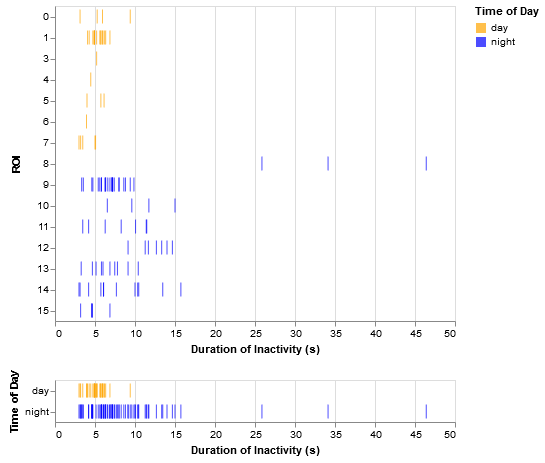

In [27]:
# Plot inactivity for jellyfish individually
p1 = alt.Chart(df_inactive, 
    ).mark_tick(
    ).encode(
        x=alt.X('Inactivity:Q', title = "Duration of Inactivity (s)"),
        y=alt.Y('ROI:N', title='ROI'),
        color=alt.Color('Condition:N', 
                        title='Time of Day',
                        scale=alt.Scale(domain=['day', 'night'],range=['orange', 'blue']))
    )
# Plot inactivity for jellyfish overall
p2 = alt.Chart(df_inactive 
    ).mark_tick(
    ).encode(
        x=alt.X('Inactivity:Q', title = "Duration of Inactivity (s)"),
        y=alt.Y('Condition:N', 
                title='Time of Day'
                ),
        color=alt.Color('Condition:N', 
                title='Time of Day',
                scale=alt.Scale(domain=['day', 'night'],range=['orange', 'blue']))
    )
# Show plots on top of one another. 
p1 & p2 

Wow! The difference here is night and day! (hehe)

Clearly, almost all jellyfish rest for longer periods, and also rest more frequently at night rather than during the day. **We can say with some confidence that this resting behavior, or pauses in oscillatory behavior, are the clearest indication of sleep in jellyfish.** Furthermore, they seem to prefer sleeping at night! This is an especially interesting adaptation for an organism with no eyes, and relatively simple sensory system. An interesting future experiment could be to test whether these patterns of sleep during night and day are light-dependent by keeping the lights on during the night, or by timing the lights turning off and on irregularly. We could also test how sleep patterns are affected when the jellyfish are disturbed during periods of inactivity to deprive them of sleep for a period. It would also be interesting to measure the pulsing from multiple angles and compare the data.

<p style="background-color:#D9EDF7">
    <b>Total: 49/50</b><br>
    Great work!  In particular, your explanations of the thought process behind each step in the workflow and your documentation of the analysis code were excellent.<br>
</p>